# Лабараторная работа 1
Вариант 11

#### **Цель работы:**
Научиться реализовывать один из алгоритмов глубокого обучения.

#### **Задание:**
1. Скачайте датасет [CarDatasets](https://drive.google.com/drive/folders/1pkudEBabqbXMxRTgfGQs3e0VqfTjtqWU)
2. Реализуйте ResNet-101 с оптимизатором [Adabound](https://arxiv.org/abs/1902.09843v1) с использованием
Numpy и с **Torch**/Tensorflow/Jax
3. Оцените качество модели на тесте и сравните быстродействие
реализованных вариантов.
4. Запустить обучение на классическом Adam и сравнить сходимость
результатов с вариантом задания.
5. Сделайте отчёт в виде readme на GitHub, там же должен быть выложен
исходный код.

#### **Отчёт должен содержать следующие пункты:**
1. Теоретическая база
2. Описание разработанной системы (алгоритмы, принципы работы,
архитектура)
3. Результаты работы и тестирования системы (скриншоты, изображения,
графики, закономерности)
4. Выводы по работе
5. Использованные источники

План:
1. Получить Dataloader, возвращающий обрезанное в соответствии с annotations изображение, убедиться, что тензор корректно конвертируется в numpy
2. Загрузить и запустить готовый resnet101. Хотя, скорее всего, это не пригодится. Запустить на нём обучение
3. Имплементировать на torch
4. Имплементирвать на numpy


* Resnet обязательно 224x224?
* Обязательно квадратные картинки?
* Лучше машина целиком в низком разрешении и мб сжатая по горизонтали или фрагмент машины?
* Rgb или gray-scale?


В датасете есть одноканальные изображения

In [2]:
import os
from collections import Counter


import scipy.io
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score


from pytorch_implementations.resnet import resnet101

C:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

In [3]:
class ResizeToNeededHeight(torch.nn.Module):
    
    def __init__(self, needed_height, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, max_size=None, antialias=None):
        super().__init__()
        #_log_api_usage_once(self)
        
        self.needed_height = needed_height
        self.max_size = max_size

        self.interpolation = interpolation
        self.antialias = antialias

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be scaled.
        Returns:
            PIL Image or Tensor: Rescaled image.
        """
        w, h = img.size
        size = (self.needed_height, round(w / h * self.needed_height))
        return torchvision.transforms.functional.resize(
            img, size, self.interpolation, self.max_size, self.antialias)

    def __repr__(self) -> str:
        detail = f"(needed_height={self.needed_height}, interpolation={self.interpolation.value}, max_size={self.max_size}, antialias={self.antialias})"
        return f"{self.__class__.__name__}{detail}"

In [29]:
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, classes = None, img_folder_path = '',
                 transform=None, crop_the_cars = True, target_transform=None):
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.img_folder_path = img_folder_path
        self.classes = classes
        self.crop_the_cars = crop_the_cars

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        x1, y1, x2, y2, class_number, img_name = self.annotations[idx]
        image = torchvision.io.read_image(
            os.path.join(self.img_folder_path, img_name))
        if self.crop_the_cars:
            image = image[:, y1:y2, x1:x2]
        #image = image.to(dtype = torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_number = self.target_transform(class_number)
        return image, class_number - 1 # В аннтоациях числа от 1 до 196
    
class CarsDatasetWithoutLabels(CarsDataset):
    def __getitem__(self, idx):
        x1, y1, x2, y2, img_name = self.annotations[idx]
        uncropped_image = torchvision.io.read_image(
            os.path.join(self.img_folder_path, img_name))
        image = uncropped_image[:, y1:y2, x1:x2]
        # image = image.to(dtype = torch.float32)
        if self.transform:
            image = self.transform(image)
        return image


In [22]:
train_cars = torchvision.datasets.StanfordCars(r'C:\Users\SystemPoint\Downloads', download = True)

In [30]:
if IN_COLAB:
    dataset_loc = r"/content/drive/MyDrive/LR1-1"
else:
    dataset_loc = r"C:\Users\SystemPoint\Downloads\LR1-1"

# train_annos содержит x1, y1, x2, y2, class, img_name для каждого изображения train
# test_annos содержит x1, y1, x2, y2, img_name для каждого изображения test
# class_names по индексу, равному числовому лейблу возвращает соответствующее имя класса
original_train_annos = scipy.io.loadmat(
    os.path.join(dataset_loc, 'cars_train_annos.mat'),
    squeeze_me = True
)['annotations']
original_test_annos = scipy.io.loadmat(
    os.path.join(dataset_loc, 'cars_test_annos.mat'),
    squeeze_me = True
)['annotations']
class_names = scipy.io.loadmat(
    os.path.join(dataset_loc, 'cars_meta.mat'),
    squeeze_me = True
)['class_names']



train_ratio = 0.85
train_size = round(len(original_train_annos) * train_ratio)
val_size = len(original_train_annos) - train_size


annos = dict()
annos['train'], annos['val'] = torch.utils.data.random_split(
    original_train_annos, [train_size, val_size],
    generator=torch.Generator().manual_seed(42))



data_transforms = dict()
data_transforms['train'] = (
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        #ResizeToNeededHeight(180),
        # torchvision.transforms.RandomRotation((-20, 20)),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        torchvision.transforms.RandomHorizontalFlip(p = 0.5),
        # torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.4),
        # torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.ToTensor(),
    ]))

data_transforms['val'] = data_transforms['test'] = (
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        #ResizeToNeededHeight(180),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.ToTensor(),
    ]))



datasets = {
    phase: CarsDataset(annos[phase], img_folder_path = os.path.join(dataset_loc, 'cars_train'), 
                       transform = data_transforms[phase], classes = class_names)
    for phase in ['train', 'val']
}

datasets['test'] = CarsDatasetWithoutLabels(
    original_test_annos,
    img_folder_path = os.path.join(dataset_loc, 'cars_test'),
    classes = class_names)




dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=8,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=8,
                                shuffle=False,
                                
                                num_workers=0),  # for Kaggle
    'test':
    torch.utils.data.DataLoader(datasets['test'],
                                batch_size=8,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [24]:
original_train_annos["fname"]

array(['00001.jpg', '00002.jpg', '00003.jpg', ..., '08142.jpg',
       '08143.jpg', '08144.jpg'], dtype=object)

In [25]:
len(datasets['train']), len(datasets['val']), len(datasets['test'])

(6922, 1222, 8041)

In [27]:
for i in datasets['train']:
    continue

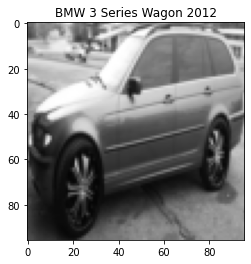

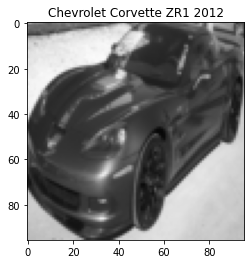

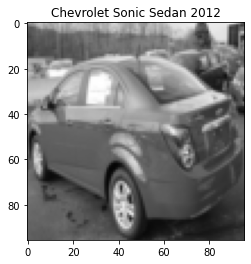

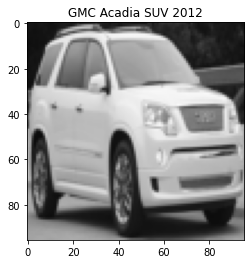

In [31]:
for i in range(4):
    image, class_number = datasets['train'][i]
    # plt.imshow(torch.Tensor(image).permute(1, 2, 0).numpy())
    plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    plt.title(datasets['train'].classes[class_number])
    plt.show()

In [ ]:
"""
min_h = 10000
indexes_less_than_3_channels = []
for i, (tensor, label) in enumerate(dataset_with_labels):
    c, h, w = tensor.shape
    min_h = min(h, min_h)
    if c < 3:
        indexes_less_than_3_channels.append(i)
        if c != 1:
            print(f"unexpected_number_of_channels: {c}")
print(f"min_h = {min_h}")
print(indexes_less_than_3_channels)
"""

In [8]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            # running_corrects = 0
            all_true_labels = []
            all_preds = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

            epoch_loss = running_loss / len(datasets[phase])
            # epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_f_score = f1_score(all_true_labels, all_preds, average = 'macro')

            print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}")
            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
"""n_classes = len(datasets['train'].classes)
model = torchvision.models.resnet101()
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)
"""

"n_classes = len(datasets['train'].classes)\nmodel = torchvision.models.resnet101()\nmodel.fc = torch.nn.Linear(model.fc.in_features, n_classes)\nmodel = model.to(device)\n"

In [12]:
n_classes = len(datasets['train'].classes)
model = resnet101(n_classes, 3)
model = model.to(device)

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [17]:
train_model(model, criterion, optimizer, num_epochs = 18)

Epoch 1/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [33:25<00:00,  2.32s/it]


train loss: 5.2841, f_score: 0.0004


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:40<00:00,  1.52it/s]


val loss: 5.2824, f_score: 0.0001
Epoch 2/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [37:06<00:00,  2.57s/it]


train loss: 5.2777, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:39<00:00,  1.53it/s]


val loss: 5.2854, f_score: 0.0001
Epoch 3/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [38:43<00:00,  2.68s/it]


train loss: 5.2754, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:35<00:00,  1.60it/s]


val loss: 5.2884, f_score: 0.0001
Epoch 4/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [38:06<00:00,  2.64s/it]


train loss: 5.2796, f_score: 0.0003


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:39<00:00,  1.53it/s]


val loss: 5.2907, f_score: 0.0001
Epoch 5/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [47:03<00:00,  3.26s/it]


train loss: 5.2738, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:39<00:00,  1.54it/s]


val loss: 5.2930, f_score: 0.0001
Epoch 6/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [44:24<00:00,  3.08s/it]


train loss: 5.2732, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:37<00:00,  1.57it/s]


val loss: 5.2951, f_score: 0.0001
Epoch 7/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [40:38<00:00,  2.82s/it]


train loss: 5.2745, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:33<00:00,  1.63it/s]


val loss: 5.2967, f_score: 0.0001
Epoch 8/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [41:10<00:00,  2.85s/it]


train loss: 5.2895, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:37<00:00,  1.57it/s]


val loss: 5.2981, f_score: 0.0001
Epoch 9/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [43:36<00:00,  3.02s/it]


train loss: 5.2724, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:34<00:00,  1.62it/s]


val loss: 5.2994, f_score: 0.0001
Epoch 10/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [43:11<00:00,  2.99s/it]


train loss: 5.2893, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:35<00:00,  1.61it/s]


val loss: 5.3005, f_score: 0.0001
Epoch 11/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [41:34<00:00,  2.88s/it]


train loss: 5.2722, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:34<00:00,  1.63it/s]


val loss: 5.3015, f_score: 0.0001
Epoch 12/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [42:39<00:00,  2.96s/it]


train loss: 5.2722, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:35<00:00,  1.61it/s]


val loss: 5.3023, f_score: 0.0001
Epoch 13/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [47:00<00:00,  3.26s/it]


train loss: 5.2956, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:41<00:00,  1.51it/s]


val loss: 5.3030, f_score: 0.0001
Epoch 14/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [43:15<00:00,  3.00s/it]


train loss: 5.2726, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:33<00:00,  1.64it/s]


val loss: 5.3036, f_score: 0.0001
Epoch 15/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [46:50<00:00,  3.25s/it]


train loss: 5.2721, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:37<00:00,  1.56it/s]


val loss: 5.3042, f_score: 0.0001
Epoch 16/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [44:51<00:00,  3.11s/it]


train loss: 5.2721, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:32<00:00,  1.66it/s]


val loss: 5.3046, f_score: 0.0001
Epoch 17/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [44:58<00:00,  3.12s/it]


train loss: 5.2952, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:33<00:00,  1.64it/s]


val loss: 5.3049, f_score: 0.0001
Epoch 18/18
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [45:50<00:00,  3.18s/it]


train loss: 5.2720, f_score: 0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:32<00:00,  1.65it/s]

val loss: 5.3051, f_score: 0.0001


In [19]:
torch.save(model.state_dict(), "./pytorch_implementations/weights/my_resnet_101.h5")

In [20]:
n_classes = len(datasets['train'].classes)
model = torchvision.models.resnet101()
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [22]:
train_model(model, criterion, optimizer, num_epochs = 3)

Epoch 1/3
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [40:25<00:00,  2.80s/it]


train loss: 5.6323, f_score: 0.0032


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [02:02<00:00,  1.25it/s]


val loss: 5.6935, f_score: 0.0001
Epoch 2/3
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [39:14<00:00,  2.72s/it]


train loss: 5.3252, f_score: 0.0017


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [02:40<00:00,  1.05s/it]


val loss: 8.3768, f_score: 0.0001
Epoch 3/3
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [40:53<00:00,  2.83s/it]


train loss: 5.3007, f_score: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [02:04<00:00,  1.23it/s]

val loss: 11.5927, f_score: 0.0005


In [23]:
train_model(model, criterion, optimizer, num_epochs = 3)

Epoch 1/3
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [40:56<00:00,  2.84s/it]


train loss: 5.2991, f_score: 0.0010


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [02:01<00:00,  1.26it/s]


val loss: 11.2224, f_score: 0.0006
Epoch 2/3
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [36:24<00:00,  2.52s/it]


train loss: 5.2783, f_score: 0.0018


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [02:18<00:00,  1.11it/s]


val loss: 18.0903, f_score: 0.0003
Epoch 3/3
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [37:16<00:00,  2.58s/it]


train loss: 5.2498, f_score: 0.0022


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [01:56<00:00,  1.32it/s]

val loss: 7.5893, f_score: 0.0002


In [24]:
train_model(model, criterion, optimizer, num_epochs = 3)

Epoch 1/3
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [37:13<00:00,  2.58s/it]


train loss: 5.2401, f_score: 0.0017


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [02:12<00:00,  1.15it/s]


val loss: 7.3342, f_score: 0.0004
Epoch 2/3
----------


  0%|▏                                                                                 | 2/866 [00:08<59:08,  4.11s/it]


KeyboardInterrupt: 

In [28]:
transfer_resnet = torchvision.models.resnet18(pretrained=True)
    
for param in transfer_resnet.parameters():
    param.requires_grad = False   
    
transfer_resnet.fc = torch.nn.Sequential(
               torch.nn.Linear(transfer_resnet.fc.in_features, 128),
               torch.nn.ReLU(inplace=True),
               torch.nn.Linear(128, n_classes))

transfer_resnet = transfer_resnet.to(device)

In [30]:
train_model(transfer_resnet, criterion, optimizer, num_epochs = 8)

Epoch 1/8
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [20:07<00:00,  1.39s/it]


train loss: 5.3283, f_score: 0.0010


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:47<00:00,  3.21it/s]


val loss: 5.3574, f_score: 0.0026
Epoch 2/8
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [36:22<00:00,  2.52s/it]


train loss: 5.3252, f_score: 0.0019


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:50<00:00,  3.04it/s]


val loss: 5.3543, f_score: 0.0023
Epoch 3/8
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [36:42<00:00,  2.54s/it]


train loss: 5.3243, f_score: 0.0011


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:49<00:00,  3.10it/s]


val loss: 5.3549, f_score: 0.0019
Epoch 4/8
----------


100%|████████████████████████████████████████████████████████████████████████████████| 866/866 [35:38<00:00,  2.47s/it]


train loss: 5.3233, f_score: 0.0011


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:44<00:00,  3.42it/s]


val loss: 5.3567, f_score: 0.0021
Epoch 5/8
----------


100%|██████████████████████████████████████████████████████████████████████████████| 866/866 [1:38:41<00:00,  6.84s/it]


train loss: 5.3267, f_score: 0.0003


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:50<00:00,  3.06it/s]


val loss: 5.3412, f_score: 0.0009
Epoch 6/8
----------


 81%|████████████████████████████████████████████████████████████████▋               | 700/866 [30:02<07:07,  2.57s/it]


KeyboardInterrupt: 

In [ ]:
os.path.join('.','pytorch_implementations','weights','my_resnet_101.h5')